# RNN（循环神经网络）

# 序列模型处理的是序列数据

# 序列数据的定义(电影评价数据)

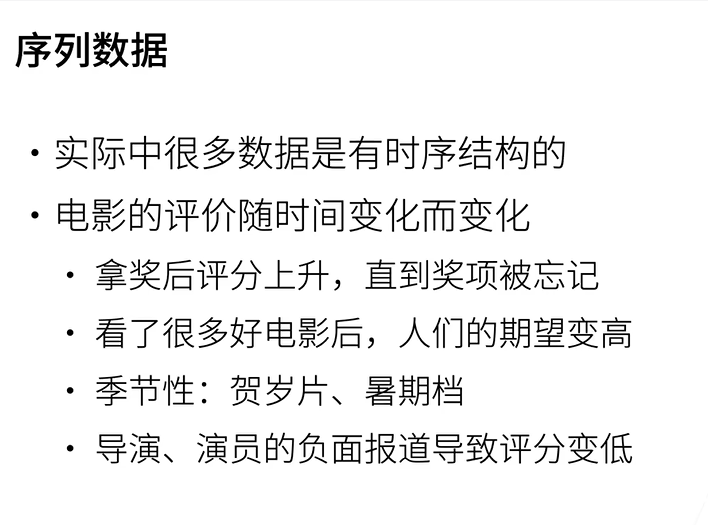

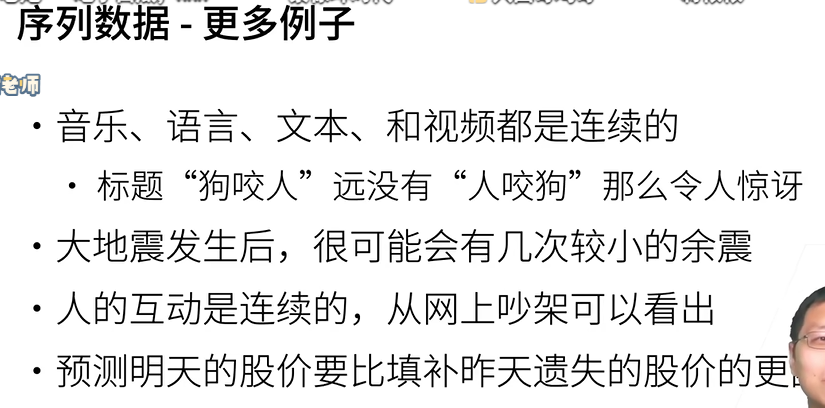

# 统计工具
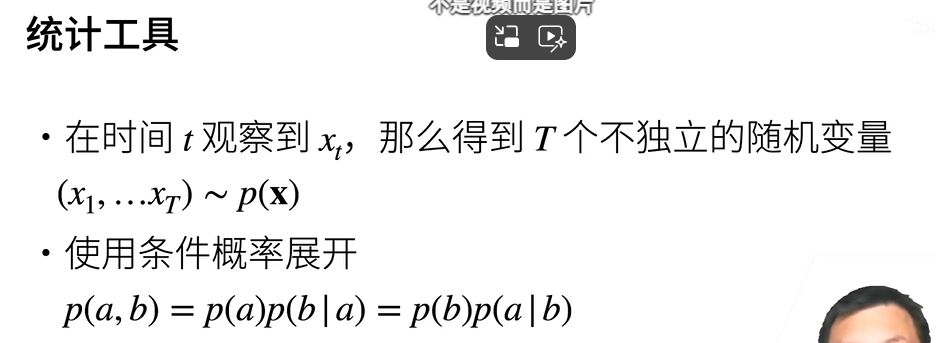

处理序列数据需要统计工具和新的深度神经网络架构


正序和反序来预测事件
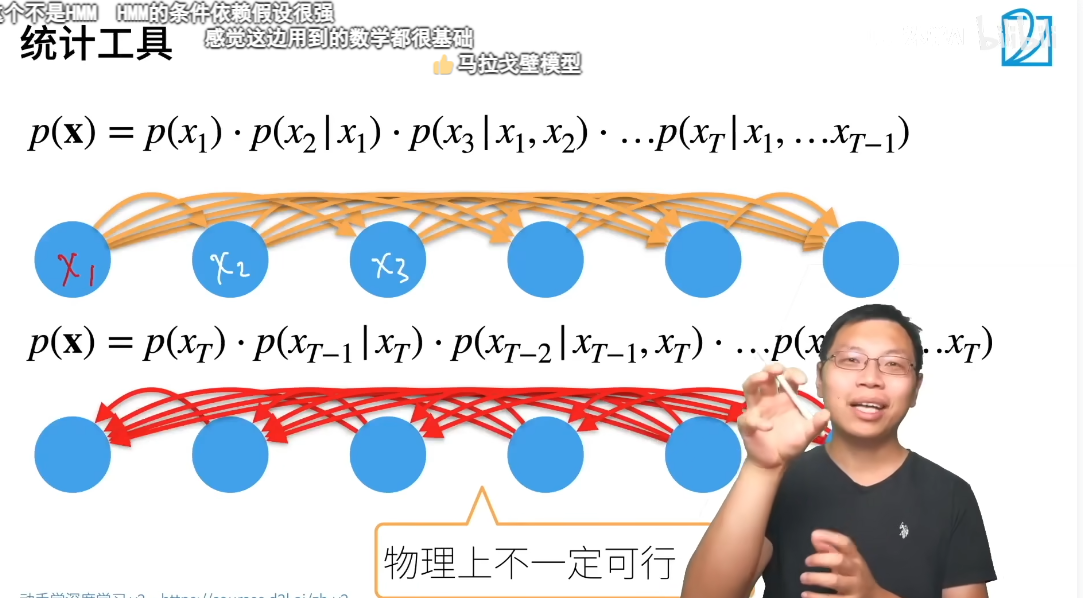

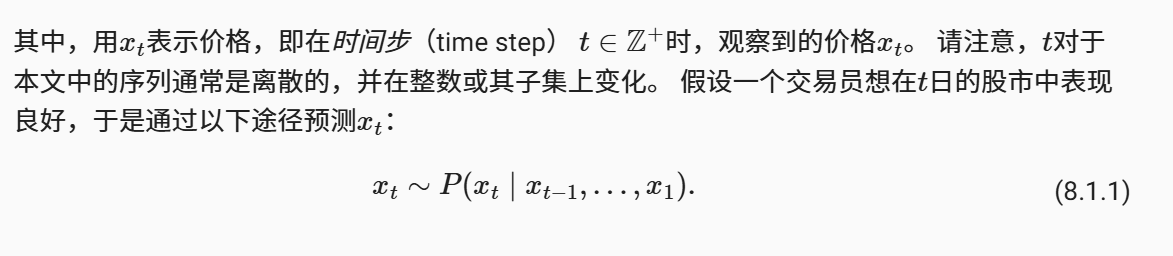

# 序列模型

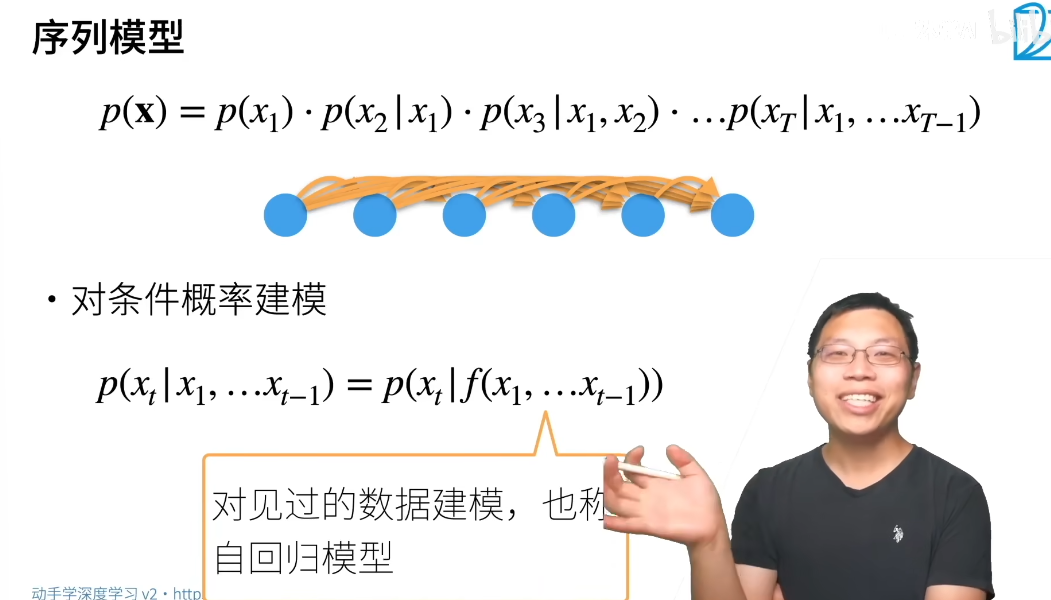

在1-t-1训练模型来预测t的事件（若为回归模型叫自回归模型）

预测的事件所得到的数据是之前出现的数据 故叫自回归模型


# 自回归模型

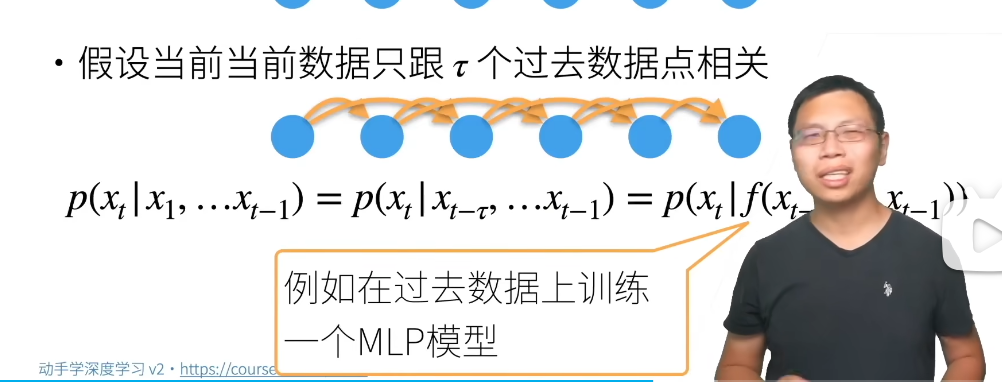

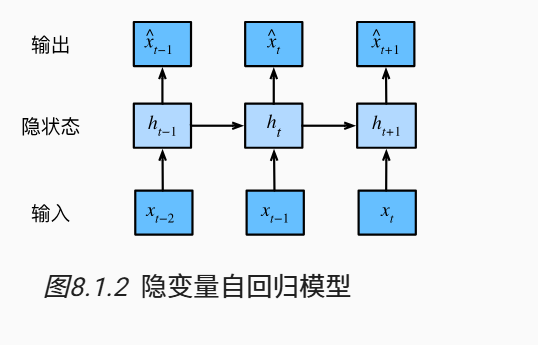

# 马尔可夫假设

当前数据只跟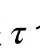个过去数据点相关

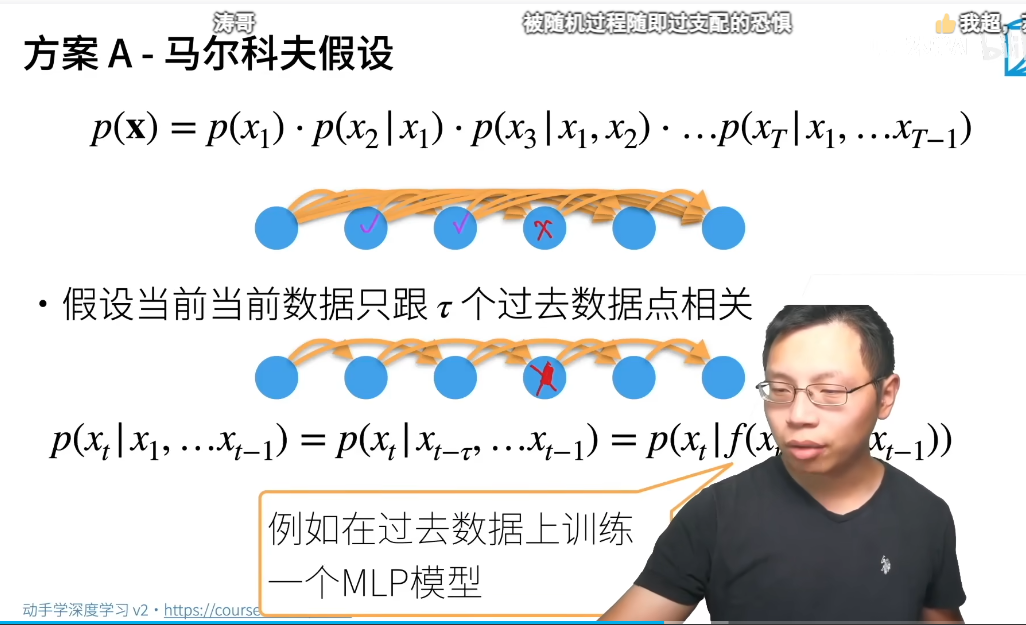

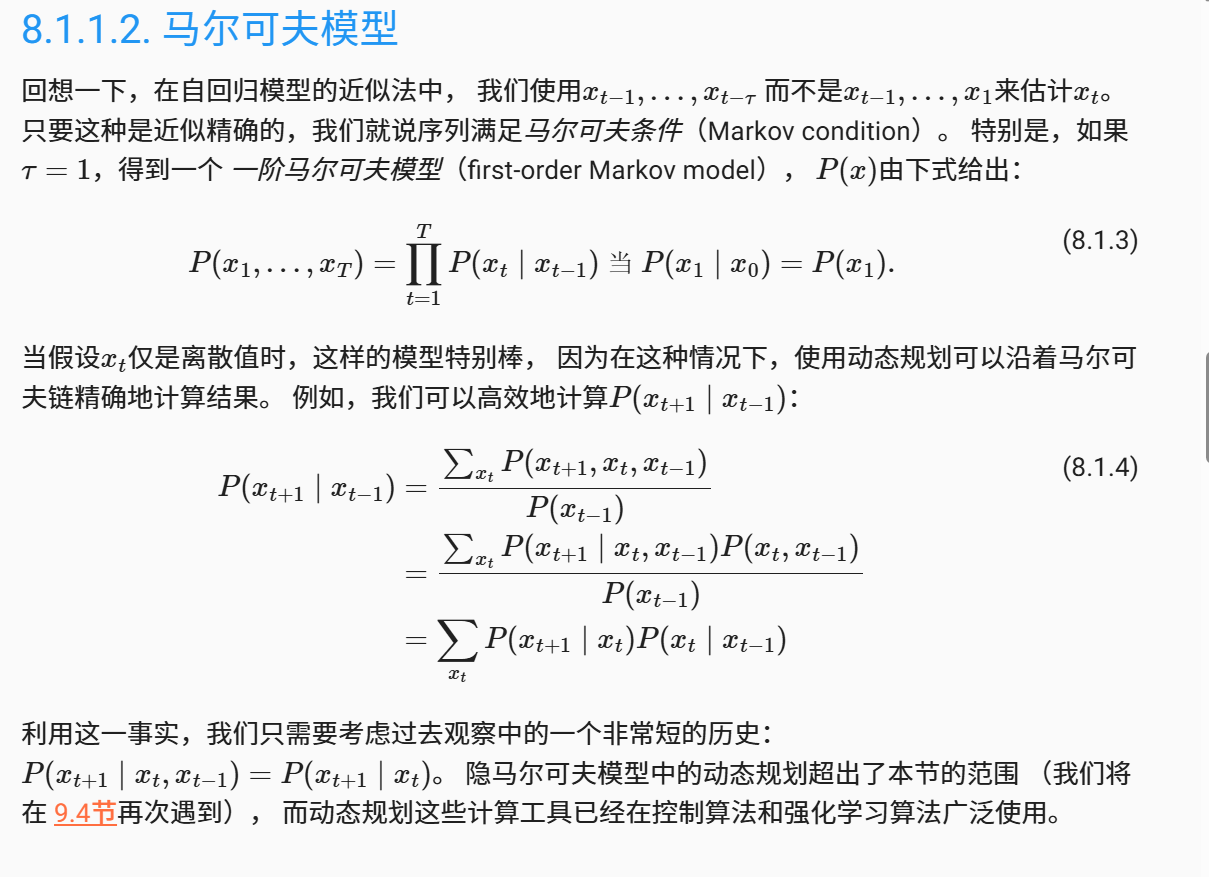

# 潜变量模型

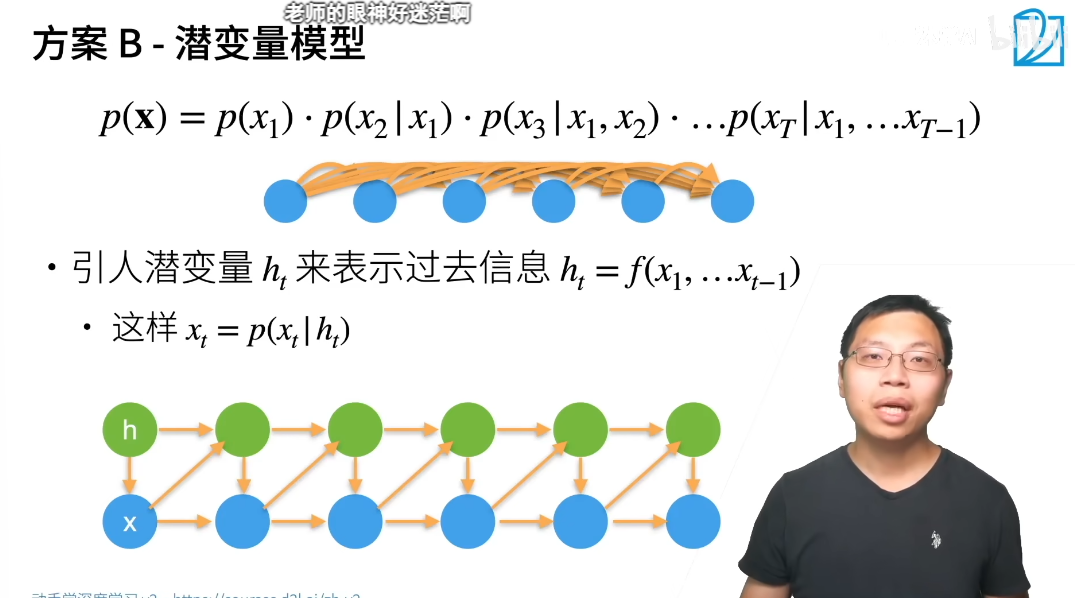

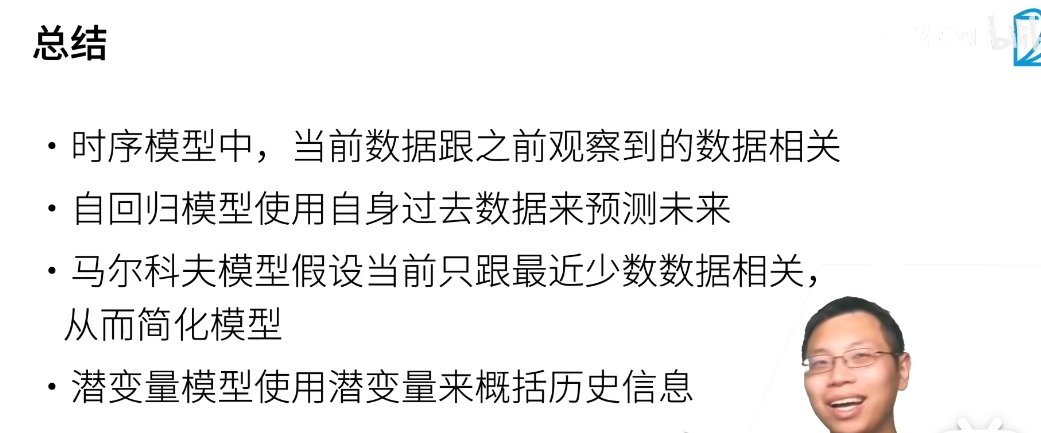

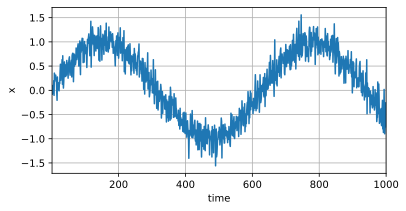

In [22]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l



#用一个正弦函数和一些可加性的噪声来生成序列数据 时间步为1-1000

# 时间1，2，3，---1000

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

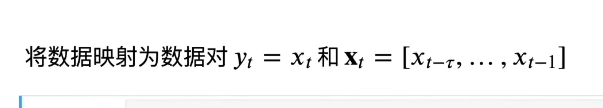

In [23]:
# 用马尔可夫假设

# 设置时间序列的延迟参数
tau = 4

# 假设 x 是一个一维时间序列数据，T 是时间序列的长度
# 创建一个特征矩阵，shape 为 (T - tau, tau)，用于存储输入特征
features = torch.zeros((T - tau, tau))

# 填充特征矩阵
for i in range(tau):
    # 从时间序列 x 中提取相应的切片，并填充到 features 矩阵的第 i 列
    # x[i: T - tau + i] 提取了从第 i 个时刻到第 T - tau + i 个时刻的数据
    features[:, i] = x[i: T - tau + i]

# 创建标签矩阵，标签为时间序列数据从 tau 开始到结束的值
# 这里 labels 的形状为 (T - tau, 1)
labels = x[tau:].reshape((-1, 1))

# 设置训练时的批量大小和训练样本数量
batch_size, n_train = 16, 600

# 仅使用前 n_train 个样本用于训练
# load_array 函数将 features 和 labels 加载为训练数据迭代器
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                             batch_size, is_train=True)

In [24]:
# 使用简单的架构训练模型 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失
# 初始化网络权重的函数
import torch
import torch.nn as nn

# 权重初始化函数
def init_weights(m):
    # 检查模块 m 是否为线性层
    if type(m) == nn.Linear:
        # 使用 Xavier 均匀分布初始化权重
        nn.init.xavier_uniform_(m.weight)

# 定义一个简单的多层感知机模型
def get_net():
    # 创建一个顺序模型，包括一个线性层、ReLU 激活层和另一个线性层
    net = nn.Sequential(
        nn.Linear(4, 10),  # 第一个线性层，输入维度为 4，输出维度为 10
        nn.ReLU(),         # ReLU 激活函数
        nn.Linear(10, 1)   # 第二个线性层，输入维度为 10，输出维度为 1
    )
    # 将定义的初始化函数应用到模型的每一层
    net.apply(init_weights)
    return net

# 定义均方误差损失函数
# 注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [25]:
# 训练函数
def train(net, train_iter, loss, epochs, lr):
    # 初始化 Adam 优化器，用于更新网络的参数
    trainer = torch.optim.Adam(net.parameters(), lr)

    # 开始训练过程
    for epoch in range(epochs):
        # 遍历训练数据迭代器
        for X, y in train_iter:
            trainer.zero_grad()  # 清零梯度，准备反向传播

            # 计算网络的输出和损失
            l = loss(net(X), y)  # 将输入 X 传入网络，计算损失

            l.sum().backward()  # 对损失进行反向传播，计算梯度
            trainer.step()      # 更新网络参数

        # 每个 epoch 完成后输出当前的损失状态
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


# 获取网络模型
net = get_net()

# 进行训练，训练周期为 5，学习率为 0.01
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.102214
epoch 2, loss: 0.057133
epoch 3, loss: 0.051130
epoch 4, loss: 0.048448
epoch 5, loss: 0.047481


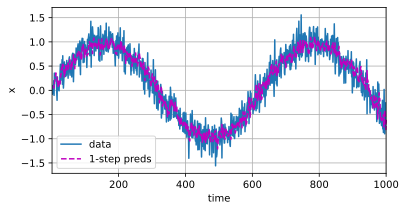

In [26]:
# 使用模型进行一步预测
onestep_preds = net(features)

# 可视化实际数据与预测数据
d2l.plot(
    [time, time[tau:]],  # x 轴数据，time 是时间序列，time[tau:] 是去掉前 tau 个数据后的时间序列
    [x.detach().numpy(), onestep_preds.detach().numpy()],  # y 轴数据，实际数据与预测数据
    'time',  # x 轴标签
    'x',     # y 轴标签
    legend=['data', '1-step preds'],  # 图例
    xlim=[1, 1000],  # x 轴的范围限制
    figsize=(6, 3)   # 图形的大小
)

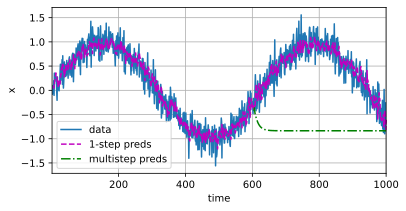

In [27]:
# 进行多步预测
# 使用已训练的神经网络 net 对时间序列数据进行多步预测并可视化结果
# 创建一个用于存储多步预测的张量
multistep_preds = torch.zeros(T)

# 初始化前 n_train + tau 个值为真实数据
multistep_preds[: n_train + tau] = x[: n_train + tau]

# 使用循环对时间序列进行多步预测
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))  # 将过去的 tau 个预测值作为输入

# 可视化实际数据，一步预测和多步预测
d2l.plot(
    [time, time[tau:], time[n_train + tau:]],  # x 轴：时间数据
    [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],  # y 轴：实际数据，一步预测和多步预测
    'time',  # x 轴标签
    'x',     # y 轴标签
    legend=['data', '1-step preds', 'multistep preds'],  # 图例标识
    xlim=[1, 1000],  # 限制 x 轴的范围
    figsize=(6, 3)   # 设置图形的大小
)

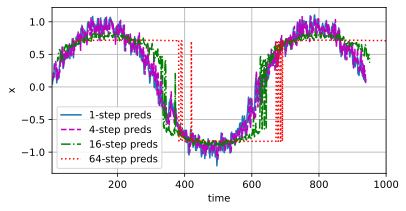

In [28]:
max_steps = 64  # 最大预测步数设定为 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 创建一个 (T - tau - max_steps + 1) 行和 (tau + max_steps) 列的零矩阵。
# 列 i（i < tau）用于存储来自输入 x 的观测值，其时间步从 i 到 (i + T - tau - max_steps + 1)
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
    # 在 features 矩阵中填充来自 x 的观测值，观测值从 x 的第 i 个元素开始，取 T-tau-max_steps+1 个元素

# 列 i（i >= tau）用于存储来自 (i-tau+1) 步的预测值，其时间步同样从 i 到 (i + T - tau - max_steps + 1)
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
    # 使用神经网络 net 预测时间序列的数据，输入为 features 的前 tau 列，输出重塑为一维数组，并存储到 features 的新列中

steps = (1, 4, 16, 64)  # 定义预测的步数
# 绘制不同预测步数的预测结果，使用时间序列的对应范围作为 x 轴
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))
# plotting: 
# time[tau + i - 1: T - max_steps + i] 提取时间序列的相应部分
# features[:, (tau + i - 1)].detach().numpy() 将 Tensor 转换为 NumPy 数组以便绘图
# 设置图例、x轴范围和图形大小

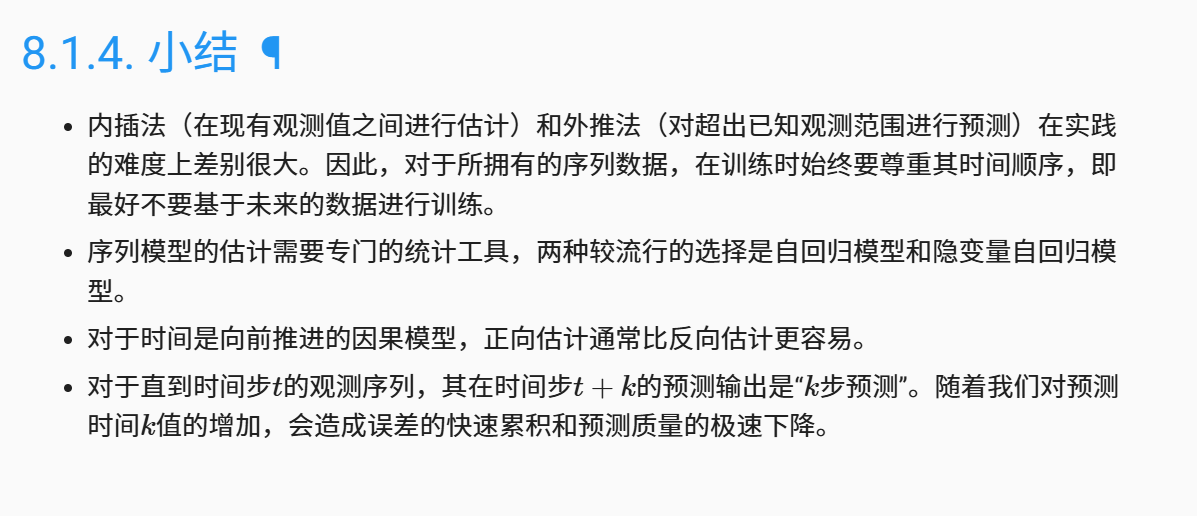